25.610003
Original tiff:


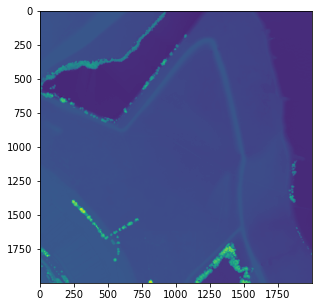

Theshold= 15
Geglättet:


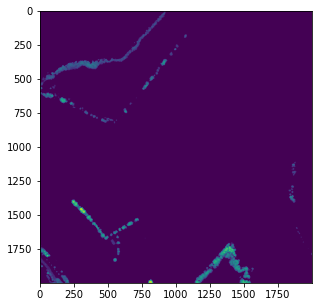

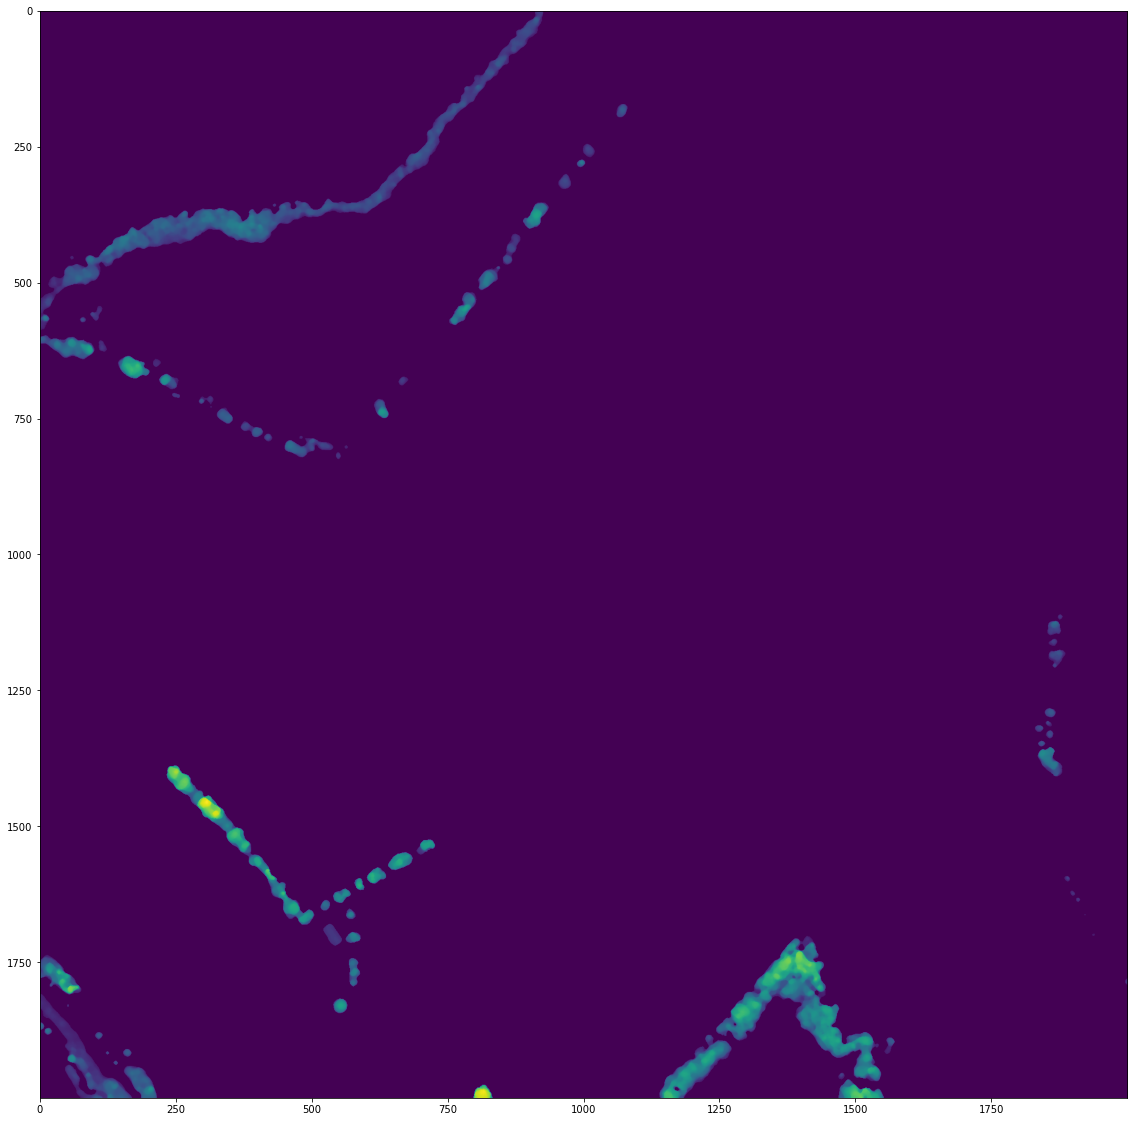

In [1]:
from scipy import ndimage as ndi
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import img_as_float
from PIL import Image
import numpy
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline  
#setze größe der geplotteten bilder:
plt.rcParams['figure.figsize'] = [5, 5]

#lade bild als numpy.array
bdom_file = "ndom50_32324_5729_1_nw_2018.tif"
im = numpy.array(Image.open(bdom_file))
#scaliere in pixel-werte größer 0
m = - numpy.min(im)
#im = im + m

#scaliere in range(0,255) und als integer-array:
m = numpy.max(im)
print(m)
im = ((im/m) *255).astype(numpy.int32)

print("Original tiff:")
plt.imshow(im)
plt.show()

#setze alle pixelwerte < thresshold = 0, um den boden zu glätten
#sonst werden bei jeder kleinen bodenwelle lokale maxima gefunden
threshhold = 15 #(numpy.max(im) - numpy.min(im)) * 0.02
print("Theshold=", threshhold)
im = numpy.where(im > threshhold, im, 0) # 0.3,
print("Geglättet:")

plt.imshow(im)
plt.show()
##gaussischer filter (falsch!):
#print("Weichzeichnen:")
#im = gaussian_filter(im, sigma=3)
#median filter
im = median_filter(im, size=10)


#setze größe der geplotteten bilder:
plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(im)
plt.show()


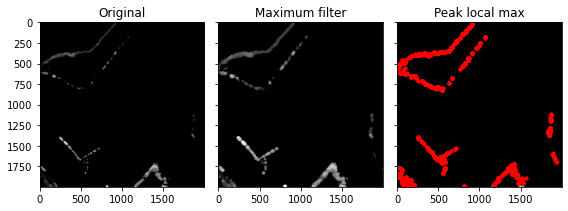

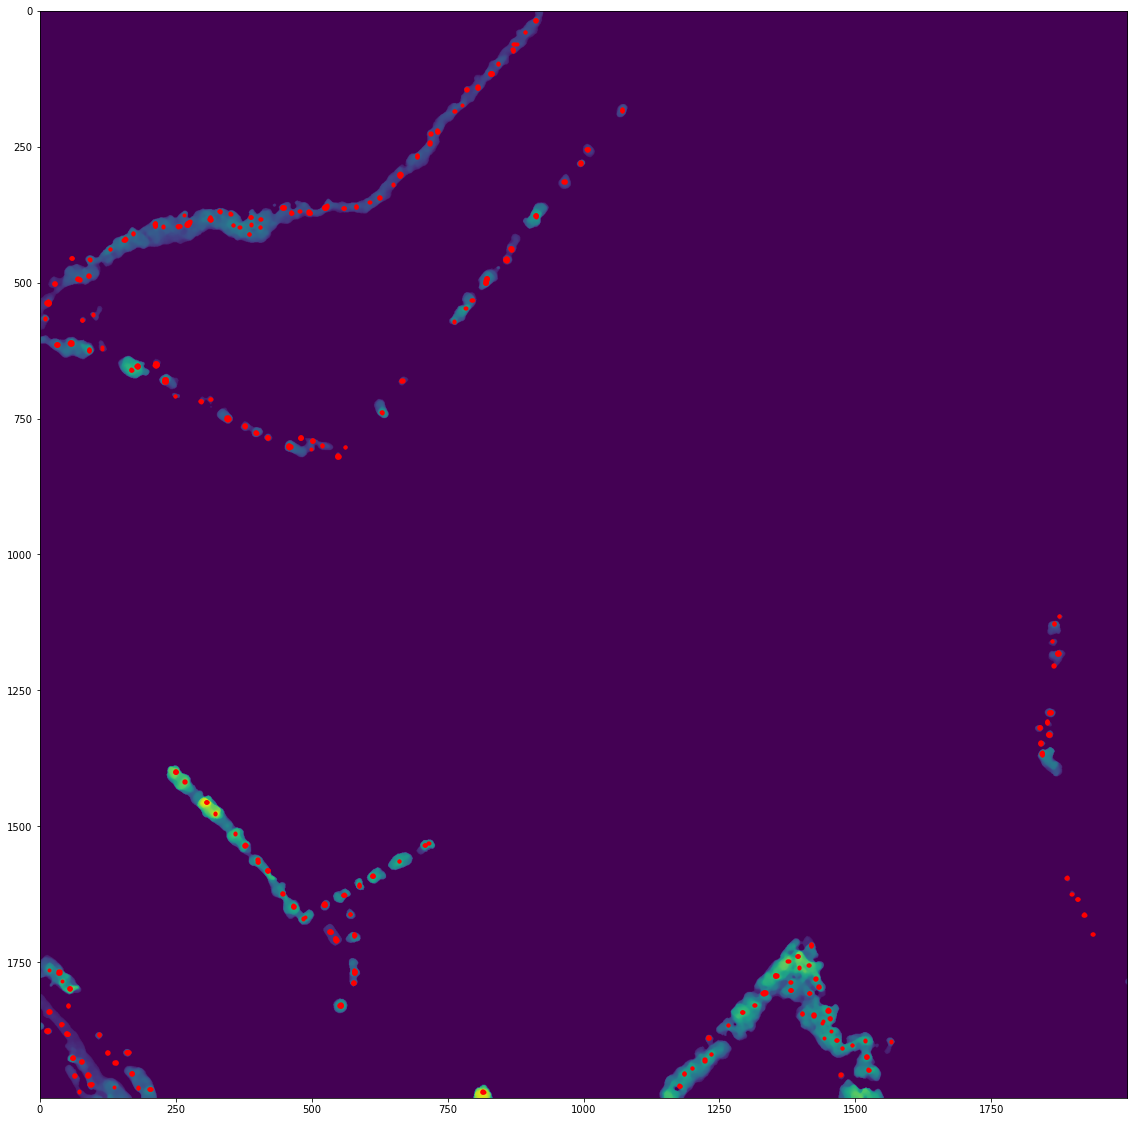

In [2]:
#wenn hier die maxima im einfarbigen bereich auftauchen, ist der threshold oben zu niedrig
#hier kann über den min-distance-wert skaliert werden:
filter_size = 15
min_distance = 9

image_max = ndi.maximum_filter(im, size=filter_size, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im, min_distance=min_distance)




# display results:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].set_title('Maximum filter')

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()

plt.imshow(im)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
plt.show()


In [3]:
import laspy

las_file = "lidar-files/1original/Wesel/3dm_32_324_5729_1_nw.laz"
las = laspy.read(las_file)



In [4]:
las_points_x = numpy.array(las.points['x']) 
las_points_y = numpy.array(las.points['y'])
x_max, x_min, y_max, y_min = las_points_x.max(),  las_points_x.min(), las_points_y.max(),  las_points_y.min()
x_range = x_max - x_min
y_range = y_max - y_min
print(x_max, x_min,x_range, y_max, y_min, y_range)

324999.99 324000.0 999.9899999999907 5729999.99 5729000.0 999.9900000002235


In [5]:
import pandas

#koordinaten vom geotiff  bestimmen - > utm koodinate jedes pixels ableiten  - > die coordiates-liste umrechnen 
#- > nächste punkte bestimmen
#load metadata csv
meta_data = pandas.read_csv("metadata/ndom_nw.csv", sep=";")
kachelname = bdom_file.split("/")[-1].split(".")[0]
row = meta_data.loc[meta_data['Kachelname'] == kachelname]

#cpnvert coordinates to ut coords_
x_pixels, y_pixels = im.shape[1],im.shape[0]
step = row['Aufloesung_cm'].values[0]/10  #0.5m per pixel!
utm_coordinates = numpy.zeros((len(coordinates), 2))
for i in range(len(utm_coordinates)):
    utm_coordinates[i][0] = coordinates[i][0] * step + x_min
    utm_coordinates[i][1] = y_max - coordinates[i][1] * step


In [15]:
#check utm_coordinates:
import folium
map = folium.Map(location=[x_max, y_max], tiles='CartoDB positron', zoom_start=11 , crs='EPSG25832')
map#

In [8]:
from scipy.spatial import distance
from tqdm import tqdm
#find list of nearest points in las:    
centroids_in_las = numpy.zeros((len(utm_coordinates), 3))
las_points = numpy.array((las.points['x'], las.points['y'])).transpose()
print(las_points)
for i in tqdm(range(len(utm_coordinates))):
        closest_index = distance.cdist([ utm_coordinates[i]], las_points).argmin()
        centroids_in_las[i] = las.points['x'][i], las.points['y'][i],las.points['z'][i]
print(centroids_in_las)


[[ 324002.96 5729014.58]
 [ 324003.8  5729015.35]
 [ 324005.4  5729003.34]
 ...
 [ 324980.73 5729998.87]
 [ 324980.48 5729999.97]
 [ 324986.5  5729993.5 ]]


100%|██████████| 1491/1491 [00:54<00:00, 27.15it/s]

[[3.24002960e+05 5.72901458e+06 1.38600000e+01]
 [3.24003800e+05 5.72901535e+06 1.39100000e+01]
 [3.24005400e+05 5.72900334e+06 1.39000000e+01]
 ...
 [3.24029850e+05 5.72900126e+06 1.39400000e+01]
 [3.24029910e+05 5.72900168e+06 1.39600000e+01]
 [3.24029960e+05 5.72900204e+06 1.39900000e+01]]


0 Nie klassifiziert
1 Nicht zugewiesen
2 Oberfläche
3 Niedrige Vegetation
4 Mittelhohe Vegetation
5 Hohe Vegetation
6 Gebäude
7 Tiefpunkt
8 Reserviert
9 Wasser
10 Schienen
11 Straßenbelag
12 Reserviert
13 Schutzdraht (Schild)
14 Drahtleiter (Phase)
15 Strommast
16 Leitungsverbinder (Isolator)
17 Brückenfahrbahn
18 Hohes Rauschen

In [16]:
import clustering
used_classifications = [0, 1]
points_to_cluster = numpy.array([[las.points['x'][i], las.points['y'][i], las.points['z'][i]] for i in tqdm(range(len(las.points['x']))) if (las.points['classification'][i] in used_classifications)]) 
#geht das mit fiter vielleicht schneller? 1:30 ist viel zu langsam..

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


100%|██████████| 4334748/4334748 [01:00<00:00, 71836.54it/s]


In [ ]:
#print(centroids_in_las)
print(points_to_cluster)

clustering.k_means_no_dbscan(centroids_in_las, points_to_cluster)

[[3.24038450e+05 5.72900171e+06 1.64600000e+01]
 [3.24038540e+05 5.72900234e+06 1.70100000e+01]
 [3.24038810e+05 5.72900168e+06 1.60200000e+01]
 ...
 [3.24852140e+05 5.72989971e+06 1.88300000e+01]
 [3.24852190e+05 5.72990006e+06 1.89000000e+01]
 [3.24852310e+05 5.72990083e+06 1.88200000e+01]]
starting k-means:
finish!


100%|██████████| 1491/1491 [00:00<00:00, 218294.72it/s]


label_colors (1491, 3)


100%|██████████| 327044/327044 [00:04<00:00, 80491.05it/s]